## I am trying to re-build PT_MH MCMC with NN assistence.

1 step we collect the data with the usual PTMCMC

In [1]:
import os
from time import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import numpy as jnp
from functools import partial
from fastgb import fastgb
from globalfit.gb.generator import GBGenerator, fastgb_buffersize, FastGBExt
from globalfit.gb.block import GBBlock
from globalfit.gb.likelihood import GBLogLik
from globalfit.gb.likelihood_jax import GBLogLikJax
from globalfit.noise.generator import NoiseGenerator
from globalfit.gb.tools import XYZ2AET
from lisaorbits import EqualArmlengthOrbits

from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, MHMove
from eryn.utils.utility import groups_from_inds

import corner

import PTDAMH as my_mcmc

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

plt.style.use(['seaborn-v0_8-ticks','seaborn-v0_8-deep'])

# %pylab inline

mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)

%load_ext autoreload
%autoreload 2

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
GF_REPO = os.path.realpath("/Users/stas/Projects/LISA/GlobalFit/global-fit/")

Tobs = 10485760.0
dt = 5.0
bsize = 64


In [4]:
np.random.seed(42)  # fixing the noise 

_noise_file = os.path.join(GF_REPO, 'auxfiles', 'noise_pars.h5')
_gbfile = os.path.join(GF_REPO, 'auxfiles', 'gb_true.h5')

_gbcat = GBGenerator.load_catalog(_gbfile)

gb_fband = [6.216e-3, 6.219e-3]
duration = [0, 10485760.0]
_sel = (_gbcat['Frequency'] > gb_fband[0]) & (_gbcat['Frequency'] < gb_fband[1])
_list = np.where(_sel)[0]

cfg = {
    "dt":dt,
    "gb_fband": gb_fband, 
    "AET": True,
    "ignore_T_channel": True,
    "domain": 'Frequency',
    "duration": duration, 
    "inputs": [
        {"add": [{"name":"cat", "generator": GBGenerator, "list": _list}], "file": _gbfile}, 
        {"add": [{"name":"cat", "generator": NoiseGenerator}], "file": _noise_file},
    ],
    "noise_params": _noise_file
} 
block = GBBlock(config=cfg)
block.load_tdi()
block.load_noise()

print (_gbcat[_list])

[(2.14104362e-23, 0.00621747, 3.08540766e-16,  0.19122362, 4.78383106, 1.44883313, 3.24941449, 3.90238858, 0., 0., 0., 0., 0., 0., 0., 0.,  7.47269928, 0., '', 0, 0.)
 (3.50476905e-23, 0.00621856, 1.31240183e-15, -0.16938328, 4.60813132, 1.79614242, 3.5511628 , 5.81270134, 0., 0., 0., 0., 0., 0., 0., 0., 13.37559459, 0., '', 0, 0.)
 (2.45939760e-23, 0.0062182 , 5.56699233e-16, -1.08865091, 3.03280483, 1.62098072, 1.30826979, 3.55278411, 0., 0., 0., 0., 0., 0., 0., 0.,  8.28745113, 0., '', 0, 0.)]


In [5]:
def _gbll_inst(cls, nsrcs, bsize, unroll_srcs=None, unroll_tdi=None):
    return cls(
        block.tdi,
        block.noise,
        block.fmin,
        block.fmax,
        smax=nsrcs,
        fgb_ext=bsize,
        unroll_srcs=unroll_srcs,
        unroll_tdi=unroll_tdi
    )

Nsrc=3
Npar_src = 8
dim = Nsrc * Npar_src
bsize = 64

_gbll = _gbll_inst(GBLogLik, Nsrc, bsize).loglik
jllkwargs = {}
_jgbll = jax.vmap(jax.jit(_gbll_inst(GBLogLikJax, Nsrc, bsize, **jllkwargs).loglik))

GB2_loglik = jax.jit(_gbll_inst(GBLogLikJax, 2, bsize, **jllkwargs).loglik)
GB3_loglik = jax.jit(_gbll_inst(GBLogLikJax, 3, bsize, **jllkwargs).loglik)


_srcHC245 = _gbll_inst(GBLogLik, 3, bsize).ldc_to_pars(_gbcat[_list], dicts=True)
print (_srcHC245)
_srcHC24 = _srcHC245[:2*Npar_src] 

[0.33265638 0.4898206  0.5084293  0.59503018 0.76137036 0.56083053
 0.65540519 0.08676368 0.38616485 0.85278449 0.53585466 0.41571276
 0.73340688 0.38827814 0.05549038 0.29474992 0.34770719 0.7330147
 0.51520896 0.05699891 0.48268588 0.47491833 0.98187836 0.64900794]


### Run Eryn for comparison with my code

In [6]:

Nsrc = 3
Npar_src = 8
dim = Nsrc * Npar_src
cov_initial = np.diag(np.ones(dim) * 0.01 ** 2)  # Default covariance matrix


GB3_loglik = jax.jit(_gbll_inst(GBLogLikJax, 3, bsize, **jllkwargs).loglik)
print (bsize)

nwalkers = dim*2
ntemps = 10
maxTemp = 5.0
temps = np.logspace(0, np.log10(maxTemp), ntemps)
print (1./temps)
# print (np.linspace(1, 0.1, ntemps))

priors = ProbDistContainer({_ind: uniform_dist(0, 1) for _ind in range(dim)})
ensemble = EnsembleSampler(
    nwalkers,
    dim,
    # jax.jit(_gbll_inst(GBLogLikJax, Nsrc, bsize, **jllkwargs).loglik),
    GB3_loglik,
    priors,
    tempering_kwargs={"betas": 1./temps},
    moves=[
        GaussianMove({'model_0': cov_initial}),
        StretchMove()
    ]
)

coords = np.random.multivariate_normal(_srcHC245, cov_initial, size=(ntemps, nwalkers))
coords[coords < 0] = 1e-4
coords[coords > 1] = 1 - 1e-4

64
[1.         0.83625103 0.69931579 0.58480355 0.48904257 0.40896235
 0.34199519 0.28599383 0.23916263 0.2       ]


In [7]:
out = ensemble.run_mcmc(coords, 1_000, burn=500, progress=True, thin_by=1)

100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


In [8]:
samples_Eryn_in = ensemble.get_chain()['model_0'][:, 0].reshape(-1, dim)

# fig20 = corner.corner(samples_Eryn_in[:, :8], bins=50, hist_kwargs={'density':True, 'lw':3}, 
#                     plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#                     show_titles=True, color='C0', use_math_test=True) 

# fig21 = corner.corner(samples_Eryn_in[:, 8:16], bins=50, hist_kwargs={'density':True, 'lw':3}, 
#                     plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#                     show_titles=True, color='C0', use_math_test=True) 

# fig22 = corner.corner(samples_Eryn_in[:, 16:24], bins=50, hist_kwargs={'density':True, 'lw':3}, 
#                     plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#                     show_titles=True, color='C0', use_math_test=True) 

plt.show()
cov_s245 = np.cov(samples_Eryn_in.T)

In [9]:
ensembleN3 = EnsembleSampler(
    nwalkers,
    dim,
    # jax.jit(_gbll_inst(GBLogLikJax, Nsrc, bsize, **jllkwargs).loglik),
    GB3_loglik,
    priors,
    tempering_kwargs={"betas": 1./temps},
    moves=[
        GaussianMove({'model_0': cov_s245}),
        StretchMove()
    ]
)

coords = np.random.multivariate_normal(_srcHC245, cov_s245, size=(ntemps, nwalkers))
coords[coords < 0] = 1e-4
coords[coords > 1] = 1 - 1e-4

In [10]:
outN3 = ensembleN3.run_mcmc(coords, 30_000, burn=2_000, progress=True, thin_by=1)

100%|██████████| 30000/30000 [46:25<00:00, 10.77it/s] 


(1440000, 24)


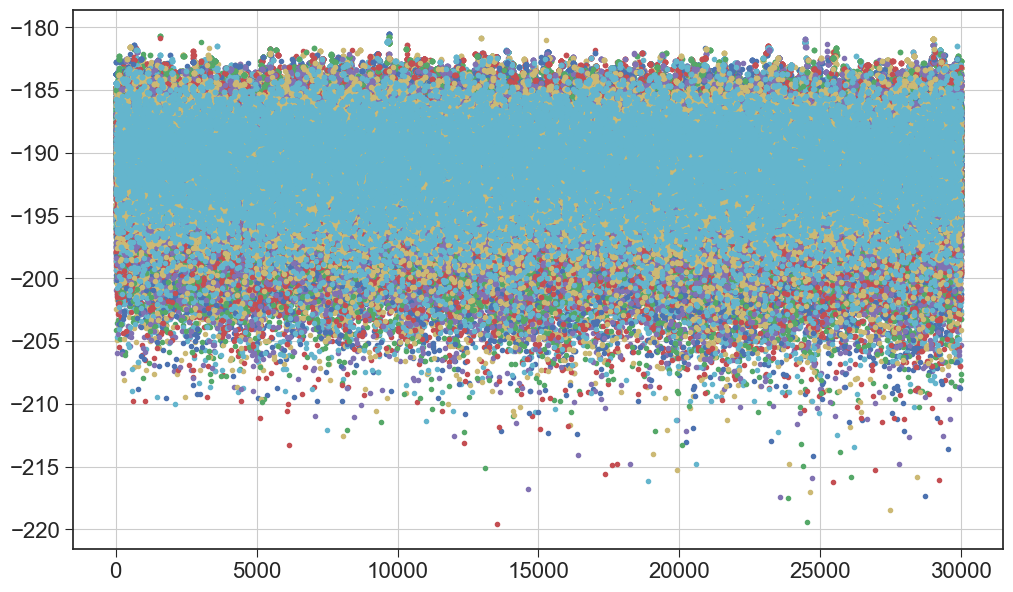

all_p shape (30000, 10, 48, 1, 24)


In [11]:
samples_Eryn_s245 = ensembleN3.get_chain()['model_0'][:, 0].reshape(-1, dim)
print (samples_Eryn_s245.shape)
ll = ensembleN3.backend.get_log_like()
for ii in range(ll.shape[2]):
    plt.plot(ll[:, 0, ii], '.', label=f'Chain {ii}')

plt.show()

all_p = ensembleN3.get_chain()['model_0']
print ('all_p shape', all_p.shape)

# G_Rratio = gelman_rubin(all_p[:, 0, :, 0, :])

# print ("Gelman - Rubin ratio", G_Rratio)

In [20]:
#Reference 
print ('loglik of last = ', GB3_loglik(samples_Eryn_s245[-1, :]))

# loglik of last =  -190.87804000788464

loglik of last =  -190.8780400078846


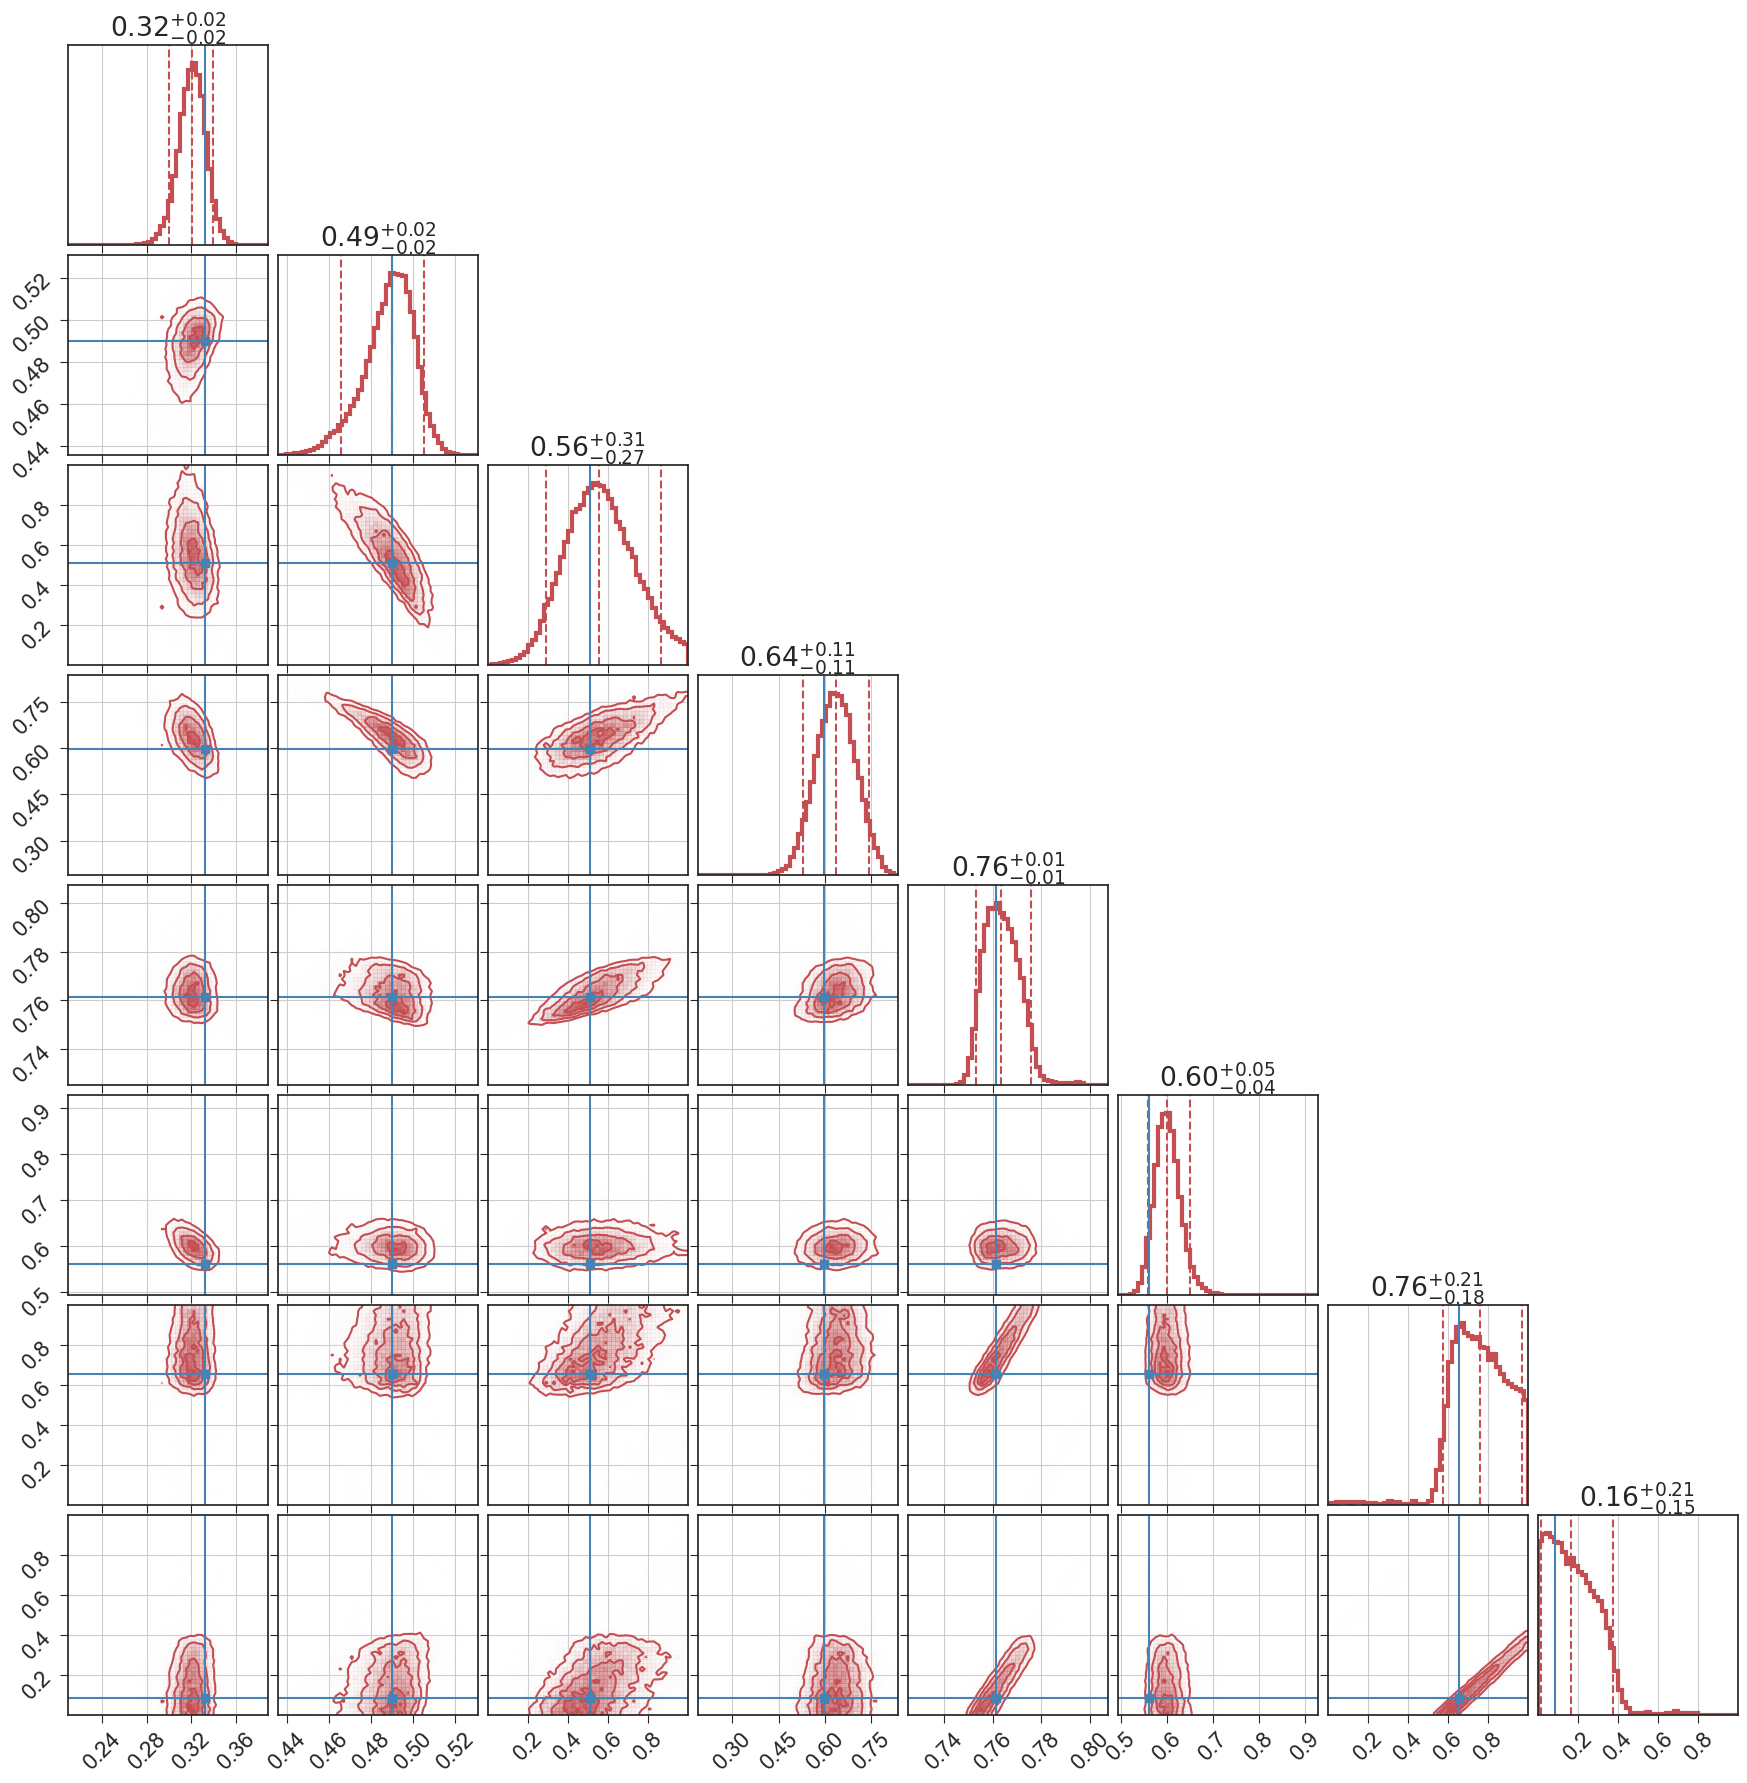

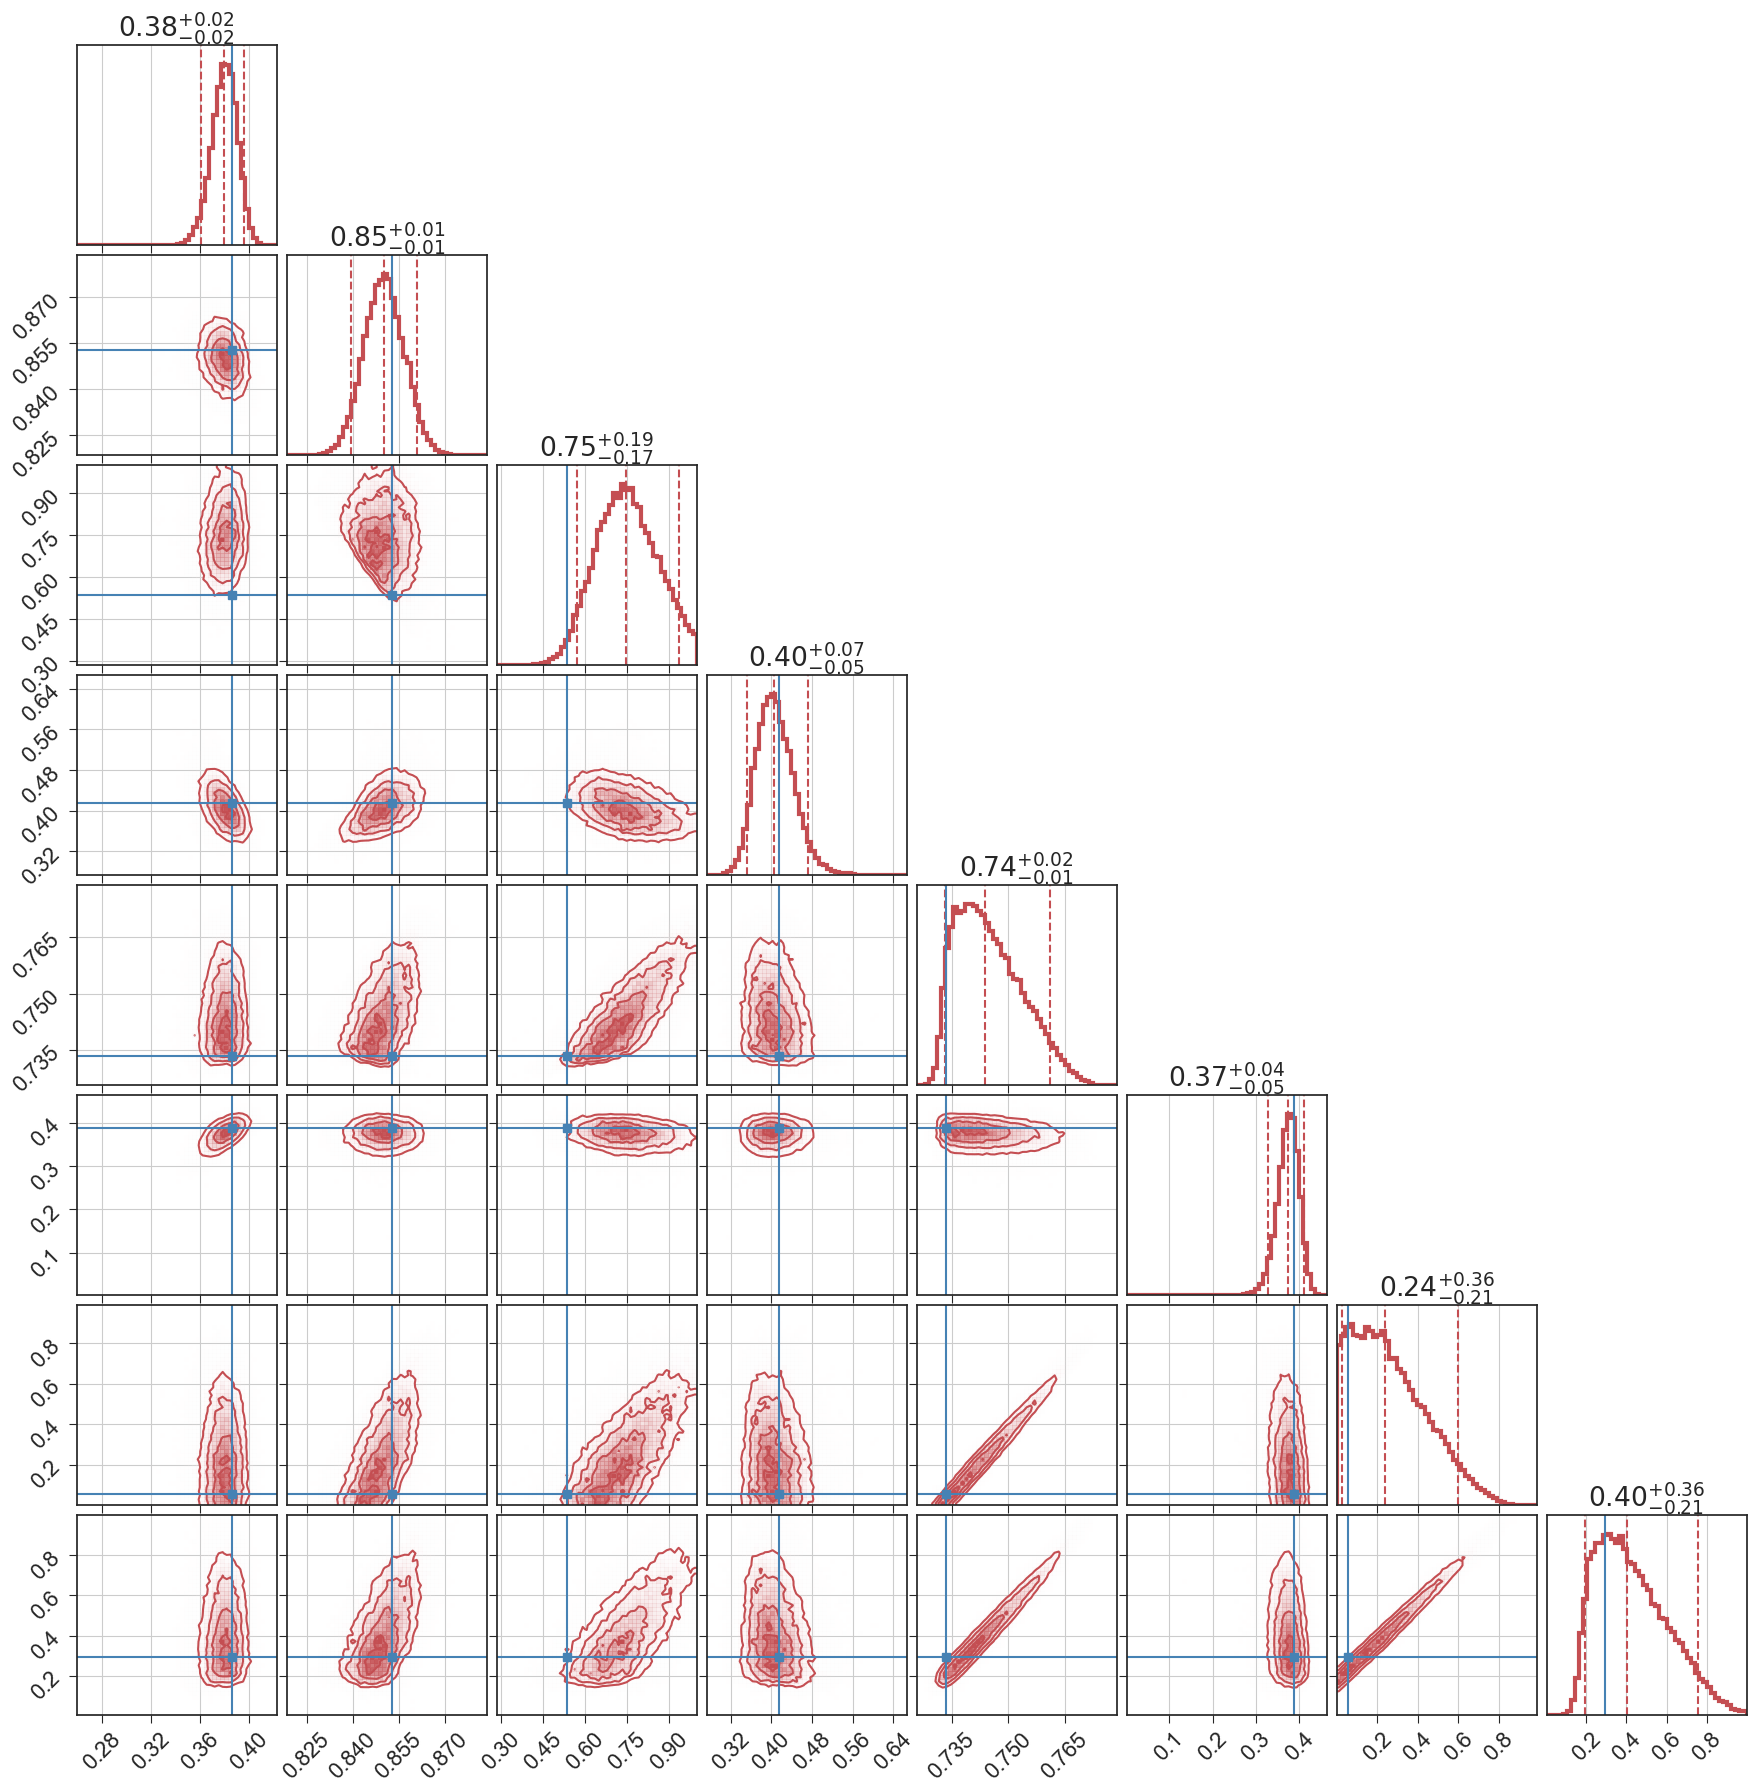

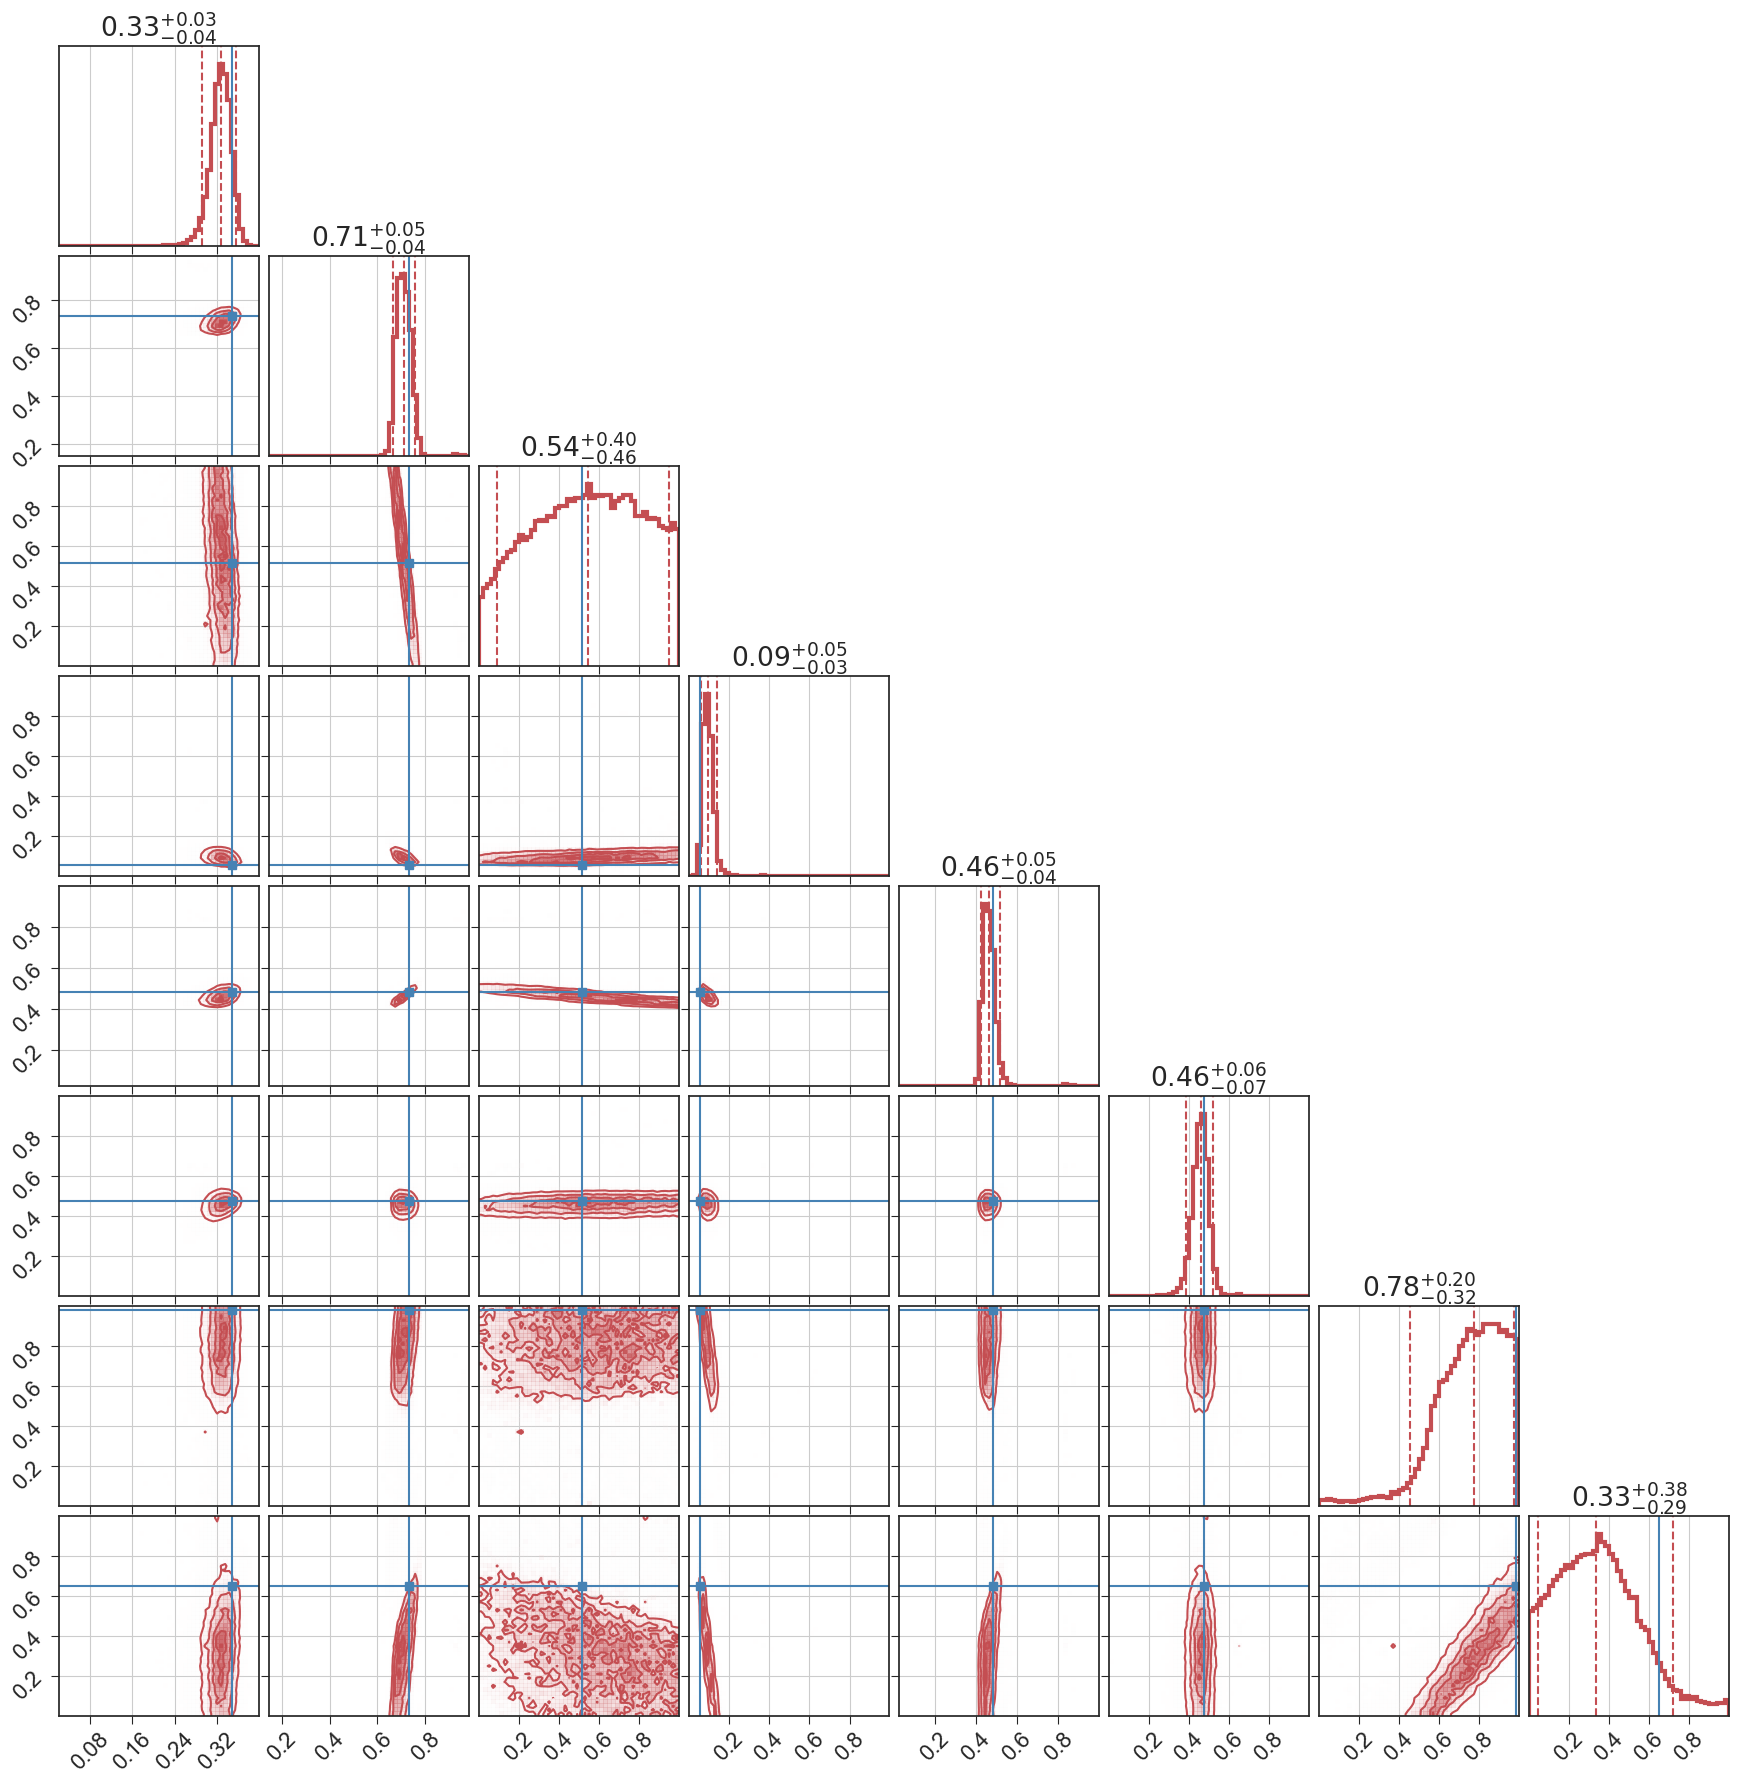

In [ ]:
fig300 = corner.corner(samples_Eryn_s245[:, :8], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[:8]) 

# corner.corner(samples_Eryn_s24[:, :8], fig=fig300,bins=50, hist_kwargs={'density':True, 'lw':3},
#               plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#               show_titles=True, color='C1', use_math_test=True, truths=_srcHC245[:8])

# line1 = mlines.Line2D([], [], color='C1', label='2 Sources')
# line2 = mlines.Line2D([], [], color='C2', label='3 Sources')

# # Add the legend to the figure
# fig300.legend(handles=[line1, line2], loc='upper right', fontsize=20)


fig310 = corner.corner(samples_Eryn_s245[:, 8:16], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[8:16]  ) 


# corner.corner(samples_Eryn_s24[:, 8:16], fig=fig310, bins=50, hist_kwargs={'density':True, 'lw':3},
#               plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#               show_titles=True, color='C1', use_math_test=True, truths=_srcHC245[8:16])

fig320 = corner.corner(samples_Eryn_s245[:, 16:24], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[16:24]) 

 
plt.show()

# np.save('chains/samples_Eryn_s245_Compar.npy', samples_Eryn_s245)

## Try my sampler 

### We start with accumulating all points for NN training. 

Start with testing the proposals
 

In [23]:
import Proposals as Proposals

In [ ]:
## central point (mean)
# mean = _srcHC245 
# cov = cov_s245
# fold_idx = (4, 6, 7)

# cov = Proposals._empirical_cov(samples_Eryn_s245)
# print (cov)


# U, S = Proposals._eig_from_cov(cov)

# Gaus_prop, logqG = Proposals.make_fullcov_proposal(jnp.asarray(cov), fold_idx=fold_idx, period=1.0)
# SCAM_prop, logqS = Proposals.make_eigenline_proposal(U, S, fold_idx=fold_idx, period=1.0)


: 